# Examples

## Example 1: 
### Calculate warming years for a 1.2C warming level for subset of models based on a temperature window approach, then pull in cmip6 data for those warming years and plot.

In [12]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from warming_years import calc_warming_years_temperature_window
from warming_years import get_cmip6_data_at_warming_years

# define the models, members, scenarios, and parameters to use
mms_table = pd.DataFrame({'model': ['GFDL-CM4', 'ACCESS-CM2'],
                          'member': ['r1i1p1f1', 'r1i1p1f1'],
                          'scenario': ['ssp585','ssp585']})
warming_level = 1.2
temp_tolerance = 0.2

# calculate the warming years
wy = calc_warming_years_temperature_window(mms_table, warming_level, 
                                           temp_tolerance)
wy


,model,member,scenario,warming_year
0,GFDL-CM4,r1i1p1f1,ssp585,2017
1,GFDL-CM4,r1i1p1f1,ssp585,2018
2,GFDL-CM4,r1i1p1f1,ssp585,2019
3,GFDL-CM4,r1i1p1f1,ssp585,2020
4,GFDL-CM4,r1i1p1f1,ssp585,2021
5,GFDL-CM4,r1i1p1f1,ssp585,2022
6,GFDL-CM4,r1i1p1f1,ssp585,2023
7,GFDL-CM4,r1i1p1f1,ssp585,2024
8,GFDL-CM4,r1i1p1f1,ssp585,2025
9,GFDL-CM4,r1i1p1f1,ssp585,2028


In [13]:
# create new common grid to interpolate to
newlats = np.arange(-90, 90.01, .5)
newlons = np.arange(-180, 180, .5)

In [15]:
# import tas data
cmip6_variable = 'tas'
year_window = 0
outfilename = None

for r in range(mms_table.shape[0]):
    model = mms_table['model'].iloc[r]
    member = mms_table['member'].iloc[r]
    scenario = mms_table['scenario'].iloc[r]
    warming_years = wy.loc[(wy['model']==model) & (wy['member']==member) & 
                           (wy['scenario'].isin(
                               [scenario,'historical']))]['warming_year']

    # get the cmip6 data
    dat = get_cmip6_data_at_warming_years(model, member, scenario, 
                                          cmip6_variable, warming_years, 
                                          year_window, outfilename)
    
    # convert K to C
    dat['tas'] = dat.tas - 273.15
    
    # interpolate to common spatial grid
    dat = dat.interp(lon=newlons, lat=newlats, method="linear")
            
    if r==0:
        tasdata = dat
    else:
        tasdata = xr.concat([tasdata,dat],dim='model')
tasdata

/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=

,Array,Chunk
Bytes,55.52 MiB,3.97 MiB
Shape,"(1, 1, 2, 14, 361, 720)","(1, 1, 1, 2, 361, 720)"
Count,562 Tasks,26 Chunks
Type,float64,numpy.ndarray


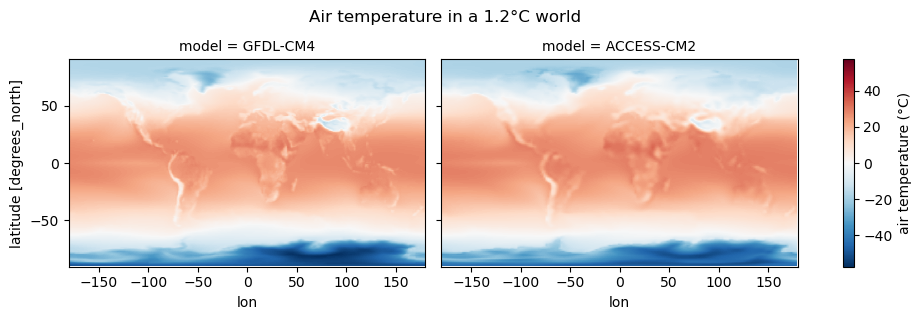

In [5]:
# Plot temperature at this warming level from each model
tasdata.mean(['member','scenario','year']).tas.plot(col = 'model', 
                                                    cmap = 'RdBu_r', 
                                                    figsize = (10,3), 
                                                    cbar_kwargs = {
                                                        'label':
                                                        'air temperature (°C)'})
plt.suptitle('Air temperature in a ' + str(warming_level) + '°C world',
             y = 1.05,
             x = 0.45)
plt.show()

## Example 2:
### Investigate the change in precipitation in a 2C world relative to a 0C world for a single model across different scenarios using a 31 year moving window approach to calculating warming years. Plot the precipitation change for each scenario.

In [6]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from warming_years import calc_warming_years_rolling_mean
from warming_years import get_cmip6_data_at_warming_years

# define the models, members, scenarios, and parameters to use
mms_table = pd.DataFrame({'model': ['ACCESS-CM2']*4,
              'member': ['r1i1p1f1']*4,
              'scenario': ['ssp126','ssp245','ssp370','ssp585']})

warming_level = 2
window_size = 15

# calculate the warming years
wy = calc_warming_years_rolling_mean(mms_table, warming_level, window_size)
wy

,model,member,scenario,warming_year
0,ACCESS-CM2,r1i1p1f1,ssp126,2042.0
1,ACCESS-CM2,r1i1p1f1,ssp245,2041.0
2,ACCESS-CM2,r1i1p1f1,ssp370,2039.0
3,ACCESS-CM2,r1i1p1f1,ssp585,2039.0


In [7]:
# create new common grid to interpolate to
newlats = np.arange(-90, 90.01, .5)
newlons = np.arange(-180, 180, .5)

In [17]:
# import precipitation data
cmip6_variable = 'pr'
year_window = window_size
outfilename = None

for r in range(mms_table.shape[0]):
    model = mms_table['model'].iloc[r]
    member = mms_table['member'].iloc[r]
    scenario = mms_table['scenario'].iloc[r]
    warming_years = wy.loc[(wy['model']==model) & (wy['member']==member) & 
                           (wy['scenario'].isin(
                               [scenario,'historical']))]['warming_year']

    # get the cmip6 data
    dat = get_cmip6_data_at_warming_years(model, member, scenario, 
                                          cmip6_variable, warming_years, 
                                          year_window, outfilename)
    
    # interpolate to common spatial grid
    dat = dat.interp(lon=newlons, lat=newlats, method="linear")
            
    if r==0:
        prdata = dat
    else:
        prdata = xr.concat([prdata,dat],dim='scenario')
prdata

/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=

,Array,Chunk
Bytes,380.74 MiB,3.97 MiB
Shape,"(2, 1, 2, 48, 361, 720)","(1, 1, 2, 1, 361, 720)"
Count,2220 Tasks,96 Chunks
Type,float64,numpy.ndarray


In [9]:
# Get the 0C world warming year data for this model/member as a baseline to 
# compare to

mms_table = pd.DataFrame({'model': ['ACCESS-CM2'],
              'member': ['r1i1p1f1'],
              'scenario': ['historical']})

warming_level = 0
window_size = 15

# calculate the warming years
wy0 = calc_warming_years_rolling_mean(mms_table, warming_level, window_size)

r=0
model = mms_table['model'].iloc[r]
member = mms_table['member'].iloc[r]
scenario = mms_table['scenario'].iloc[r]
warming_years = wy0['warming_year']

# get the cmip6 data
base = get_cmip6_data_at_warming_years(model, member, scenario, cmip6_variable, 
                                       warming_years, year_window, outfilename)
    
# interpolate to common spatial grid
base = base.interp(lon=newlons, lat=newlats, method="linear")
base

<xarray.Dataset>
Dimensions:   (scenario: 1, member: 1, model: 1, year: 23, lat: 361, lon: 720, bnds: 2)
Coordinates:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(361, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(720, 2), meta=np.ndarray>
  * year      (year) int64 1850 1851 1852 1853 1854 ... 1868 1869 1870 1871 1872
  * model     (model) <U10 'ACCESS-CM2'
  * member    (member) <U8 'r1i1p1f1'
  * scenario  (scenario) <U10 'historical'
  * lon       (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
Dimensions without coordinates: bnds
Data variables:
    pr        (scenario, member, model, year, lat, lon) float64 dask.array<chunksize=(1, 1, 1, 1, 361, 720), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/b4dd0f13-6073-4d10-b4e6-7d7a4401e37d
    variable_id:            pr
    variant_label:          r1i1p1f1
    version:                v20191108
    netcdf_tracking_ids:    hdl:21.14100/b4dd0f13-6073-4d10-b4e6-7d7a4401e37d
    version_id:             v20191108

In [10]:
# Calculate the change in precipitation relative to a 0C world for each scenario
prchange = prdata.mean(['model','member','year']) - base.mean(['model',
                                                               'member',
                                                               'scenario',
                                                               'year'])
prchange

<xarray.Dataset>
Dimensions:   (lat: 361, bnds: 2, lon: 720, scenario: 4)
Coordinates:
    lat_bnds  (lat, bnds) float64 nan nan nan nan -89.62 ... nan nan nan nan
    lon_bnds  (lon, bnds) float64 nan nan nan nan 180.1 ... 178.1 179.9 nan nan
  * scenario  (scenario) <U6 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * lon       (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
Dimensions without coordinates: bnds
Data variables:
    pr        (scenario, lat, lon) float64 dask.array<chunksize=(1, 361, 720), meta=np.ndarray>

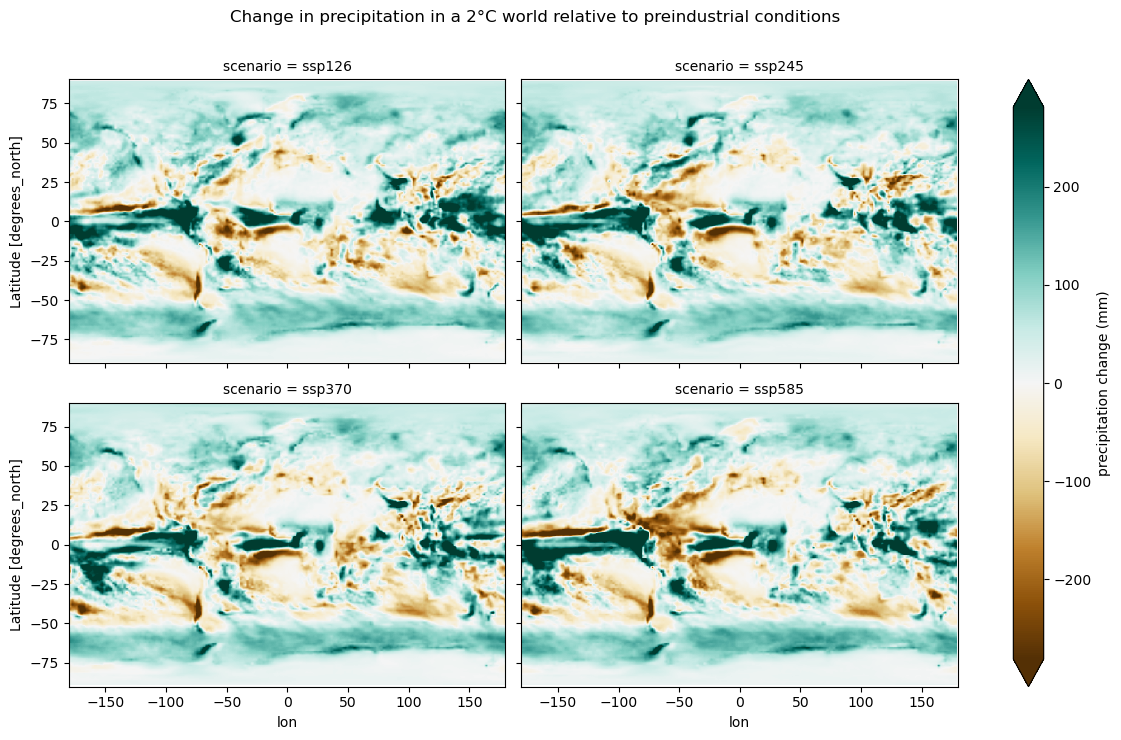

In [11]:
# Plot the change in precipitation between a 2C and a 0C world for each scenario
prchange.pr.plot(col='scenario', 
                 col_wrap=2, 
                 cmap = 'BrBG',
                 robust=True, 
                 figsize=(12,7), 
                 cbar_kwargs = {'label': 'precipitation change (mm)'})
plt.suptitle('Change in precipitation in a 2°C world relative to ' + 
             'preindustrial conditions',
             y = 1.05,
             x = 0.45)
plt.show()